In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples
from tqdm import tqdm

Now we show the interface with `kwant`. We start by using `kwant` to build two tight-binding systems with translational symmetry:
* graphene;
* a dummy system that encodes the interaction matrix.
See [`kwant_examples`](./codes/kwant_examples.py) to check how these two steps are done.

In [2]:
# Create translationally-invariant `kwant.Builder`
bulk_graphene, syst_V = kwant_examples.graphene_extended_hubbard()

We then use `utils.extract_hopping_vectors` to extract the hopping vectors of the `kwant.Builder` that encodes the interaction matrix.

In [3]:
tb_model = utils.builder2tb_model(bulk_graphene)

Finally, we use [`kwant.wraparound.wraparound`](https://kwant-project.org/doc/dev/reference/generated/kwant.wraparound.wraparound#kwant.wraparound.wraparound) to wrap the system.

With the finalized systems, we first generate an nd-array for the Hamiltonian evaluated on a $n \times n$, $n=15$, k-point grid.

In [4]:
# Compute non-interacting Hamiltonian on a coarse k-point grid
# Number of k-points along each direction
nk = 50
hamiltonians_0 = utils.kgrid_hamiltonian(nk, tb_model)

Note that this grid is rather coarse, and thus not necessarily appropriate to observables. We thus use `utils.hk_densegrid` to compute the gap.

In [18]:
def compute_gap(
    tb_model,
    int_model,
    nk,
    nk_dense,
    U,
    filling=2,
    guess=None,
):
    # Generate guess on the same grid
    if guess is None:
        guess = utils.generate_guess(nk, tb_model, int_model, scale=0.2)
    # else:
    #     guess += utils.generate_guess(
    #         nk, tb_model, int_model, scale=0.1 * np.max(np.abs(guess))
    #     )

    # Find groundstate Hamiltonian on the same grid
    mf_model, mf = hf.find_groundstate_ham(
        tb_model=tb_model,
        int_model=int_model,
        filling=filling,
        nk=nk,
        guess=guess,
        return_mf=True,
    )
    # Compute groundstate Hamiltonian on a dense grid
    scf_ham = utils.kgrid_hamiltonian(nk_dense, mf_model)
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(scf_ham)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)
    return gap, mf

Finally, we run the SCF by evaluating also the interacting matrix on a k-point grid.

In [19]:
def compute_phase_diagram(Us, Vs, nk, nk_dense):
    gap = []
    for U in tqdm(Us):
        guess = None
        gap_U = []
        for V in Vs:
            params = dict(U=U, V=V)
            _gap, guess = compute_gap(
                tb_model=utils.builder2tb_model(bulk_graphene),
                int_model=utils.builder2tb_model(syst_V, params),
                nk=nk,
                nk_dense=nk_dense,
                guess=guess, U=U
            )
            gap_U.append(_gap)
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

In [20]:
# Generate dense-grid k-points
# Interaction strengths
nk=15
nk_dense=30
Us = np.linspace(0, 3, 10, endpoint=True)
Vs = np.linspace(0, 1.5, 10, endpoint=True)
gap = compute_phase_diagram(Us, Vs, nk=nk, nk_dense=nk_dense)

100%|██████████| 10/10 [03:45<00:00, 22.59s/it]


We finally see two gapped regions in the spectrum. The bottom region is an antiferromagnetic groundstate, while the upper one is a charge density wave, as described in [arXiv:1204.4531](https://arxiv.org/abs/1204.4531).

In [21]:
import xarray as xr
gap_da = xr.DataArray(data=gap, coords=dict(Us=Us, Vs=Vs))

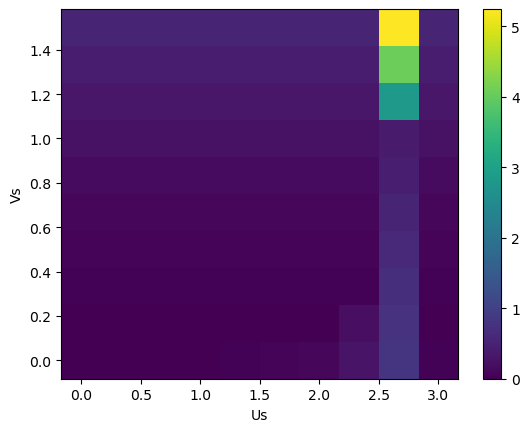

In [23]:
gap_da.plot(x='Us', y='Vs')

In [25]:
gap_da.to_netcdf('./data/graphene_example.nc')